In [1]:
%matplotlib  inline
import pandas as pd
import numpy as np
from snap import *


def  getGraph(nodes,edges):
    G = TUNGraph.New()
    ## 添加节点
    for node in nodes:
        G.AddNode(node) 
    ## 添加边
    for A,B in edges:
        G.AddEdge(A,B)
    return G


### 入度出度计算
def getInOutDegrees(UGraph=None):
    nodes_stats=[]
    for NI in UGraph.Nodes():
        temp=[NI.GetId(), NI.GetOutDeg(), NI.GetInDeg()]
        nodes_stats.append(temp)
    call_net_nodes=pd.DataFrame(data=nodes_stats,columns=['id','OutDeg','InDeg']).set_index('id')
    return call_net_nodes


##Uses the Clauset-Newman-Moore community detection method for large networks. 
# At every step of the algorithm two communities that contribute maximum positive value 
# to global modularity are merged. Fills CmtyV with all the communities detected and 
# returns the modularity of the network.
def getCNMCommDetect(UGraph=None):
    CmtyV = TCnComV()
    modularity = CommunityCNM(UGraph, CmtyV)
    comm=pd.DataFrame([list(line) for line in list(CmtyV)])
    return comm,modularity

## Uses the Girvan-Newman community detection algorithm based on betweenness centrality on Graph.
def getGNCommDetect(UGraph=None):
    CmtyV = TCnComV()
    modularity = snap.CommunityGirvanNewman(UGraph, CmtyV)
    comm=pd.DataFrame([list(line) for line in list(CmtyV)])
    return comm,modularity

## 得到由图中节点组成的子图
def getSubGraph(Graph,nodes):
    NIdV = snap.TIntV()
    for i in nodes:
        NIdV.Add(i)
    SubGraph = snap.GetSubGraph(Graph, NIdV)
    return SubGraph

def GetStats():
    diam = GetBfsFullDiam(Graph, 100, False)  ## 网络直径
    GraphClustCoeff= GetClustCf (Graph, -1)     ## 聚集系数
    NumTriads=GetTriads(Graph, 50)   ## 三元闭包的个数

# GetEdgesInOut(Graph, Nodes)  ## 社区内部边，社区外部的边，Graph可以是有向图或者无向图。Nodes是图中的节点Id
# snap.GetModularity(Graph, Nodes, 1000)  ## 又Nodes组成的社区的模块度，Gedges是可选参数，如果Gedes和实际不一样则得到的错误的模块度
# # convert undirected graph to directed
# GOut = snap.ConvertGraph(snap.PNGraph, GIn)  ## 实现无向图向有向图的转换，图类别的转换

def apply_packed_function_for_map((dumped_function, item, args, kwargs),):
    """
    Unpack dumped function as target function and call it with arguments.

    :param (dumped_function, item, args, kwargs):
        a tuple of dumped function and its arguments
    :return:
        result of target function
    """
    target_function = dill.loads(dumped_function)
    res = target_function(item, *args, **kwargs)
    return res


def pack_function_for_map(target_function, items, *args, **kwargs):
    """
    Pack function and arguments to object that can be sent from one
    multiprocessing.Process to another. The main problem is:
        «multiprocessing.Pool.map*» or «apply*»
        cannot use class methods or closures.
    It solves this problem with «dill».
    It works with target function as argument, dumps it («with dill»)
    and returns dumped function with arguments of target function.
    For more performance we dump only target function itself
    and don't dump its arguments.
    How to use (pseudo-code):

        ~>>> import multiprocessing
        ~>>> images = [...]
        ~>>> pool = multiprocessing.Pool(100500)
        ~>>> features = pool.map(
        ~...     *pack_function_for_map(
        ~...         super(Extractor, self).extract_features,
        ~...         images,
        ~...         type='png'
        ~...         **options,
        ~...     )
        ~... )
        ~>>>

    :param target_function:
        function, that you want to execute like  target_function(item, *args, **kwargs).
    :param items:
        list of items for map
    :param args:
        positional arguments for target_function(item, *args, **kwargs)
    :param kwargs:
        named arguments for target_function(item, *args, **kwargs)
    :return: tuple(function_wrapper, dumped_items)
        It returs a tuple with
            * function wrapper, that unpack and call target function;
            * list of packed target function and its' arguments.
    """
    dumped_function = dill.dumps(target_function)
    dumped_items = [(dumped_function, item, args, kwargs) for item in items]
    return apply_packed_function_for_map, dumped_items

def getNodeEdge(filename):
    df=pd.read_csv(filename,index_col=0)
    df.drop_duplicates(['cust_a','cust_b'],inplace=True)
    cond=(df.cust_a!=df.cust_b)
    df=df[cond]
    nodes=np.union1d(df.cust_a.unique(),df.cust_b.unique())
    edges=df.values
    return nodes,edges

def getGraph(filename,U=True):
    nodes,edges=getNodeEdge(filename)
    if U:
        G=TUNGraph.New()
    else:
        G=TNGraph.New()
    for node in nodes:
        G.AddNode(node) 
    ## 添加边
    for A,B in edges:
        G.AddEdge(A,B)
    return G

In [2]:
# app_conatcts=getGraph('chapter1data/app_contacts.csv')
# sms=getGraph('chapter1data/sms_net.csv')
call_record=getGraph('chapter1data/call_record_net.csv')
# %time getNodeStats(call_record).to_csv('chapter1data/call_record_nodes_stats.csv')


KeyboardInterrupt: 

In [3]:
def getNodeStats(UGraph):
    stats_df=getInOutDegrees(UGraph)
    Nodes = TIntFltH()
    Edges = TIntPrFltH()
    GetBetweennessCentr(UGraph, Nodes, Edges, 1.0)
    stats_df['BetweennessCentr']=[Nodes[node] for node in Nodes]
    stats_df['DegreeCentr']=[GetDegreeCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['ClosenessCentr']=[GetClosenessCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['FarnessCentr']=[GetFarnessCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['NodeEcc']=[GetNodeEcc(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['NodeClustCf']=[GetNodeClustCf(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['NodeTriads']=[GetNodeTriads(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    return stats_df
    

In [4]:
CDRs=pd.read_csv('chapter1data/call_record_net.csv',index_col=0)

In [5]:
%%time
import dill
import multiprocessing
CDRs_un=np.union1d(CDRs.cust_a.unique(),CDRs.cust_b.unique())
nodes=CDRs_un[np.random.randint(0,CDRs_un.shape[0],20000)]
# nodes=CDRs.cust_a.values[:10000]
pool = multiprocessing.Pool(400)
features = pool.map(
     *pack_function_for_map(
        lambda  NI:[GetNodeEcc(call_record,NI ),GetNodeClustCf(call_record,NI ),GetNodeTriads(call_record,NI ),GetFarnessCentr(call_record,NI )],
         nodes,
       
    )
)
## 最大最短路径
## 节点的聚类系数
## 节点三元闭包数量
## 节点的平均路劲长度
pd.DataFrame(features,columns=['NodeEcc','ClustCf','NodeTriads','FarnessCentr']).to_csv('chapter1data/CDRs_NodeEcc.csv')

NameError: global name 'call_record' is not defined

In [ ]:
app_conatcts=getGraph('chapter1data/app_contacts.csv',U=False)
sms=getGraph('chapter1data/sms_net.csv',U=False)
call_record=getGraph('chapter1data/call_record_net.csv',U=False)
# call_record=GetMxWcc_PNGraph(app_conatcts)    
# app_conatcts_MxWcc=GetMxWcc_PNGraph(app_conatcts)
# call_record=GetMxWcc_PNGraph(call_record)

In [ ]:
GDict={'MPC':app_conatcts,'CDR':call_record,'SMS':sms}

In [ ]:
# app_conatcts.GetNodes()
vs_es=lambda  g:[g.GetNodes(),g.GetEdges(),g.GetEdges()/float(g.GetNodes())]

In [ ]:
scc_rate=lambda g:GetMxWcc(g).GetNodes()/float(g.GetNodes())


In [ ]:
for x,y in GDict.iteritems():
    print x,scc_rate(y)

In [ ]:
%%time
import dill
import multiprocessing
# filename='chapter1data/sms_MxWcc.out'
sample_num=5*10000

save_fileanme='chapter1data/CPC_mx_stats.csv'
# call_record=LoadPajek_PUNGraph(filename)
CDRs=[NI.GetId() for NI in call_record.Nodes()]
print 'number of Nodes:',len(CDRs)
nodes=np.array(CDRs)[np.random.randint(1,len(CDRs),sample_num)]
pool = multiprocessing.Pool(300)
features = pool.map(
     *pack_function_for_map(
        lambda  NI:[GetFarnessCentr(call_record,NI )],
         nodes,
       
    )
)
## 最大最短路径
## 节点的聚类系数
## 节点三元闭包数量
## 节点的平均路劲长度
pd.DataFrame(features,columns=['Farness'],index=nodes).to_csv(save_fileanme)

In [ ]:
CPC_mx=pd.DataFrame(features,columns=['Deg','NodeEcc','ClustCf','NodeTriads'],index=nodes)

In [ ]:
sms_mx=pd.read_csv('chapter1data/sms_MxWcc_stats.csv',index_col=0)

In [ ]:
sms_mx.describe()

In [ ]:
CPC_mx.describe()

In [ ]:
CDRs.describe()

In [ ]:

import matplotlib.pyplot as plt
import matplotlib
from pylab import mpl
myfont = matplotlib.font_manager.FontProperties(fname='../fonts/simhei.ttf')  
mpl.rcParams['axes.unicode_minus'] = False 

def GetPlotClust(df):
    df_cut=pd.cut(df.ClustCf,bins=11,labels=np.arange(0,1.1,0.1))
    df_cut_cnt=df_cut.value_counts()
    df_stats=(df_cut_cnt/df_cut_cnt.sum()).sort_index()
    return df_stats
ax=GetPlotClust(sms_mx).plot.bar(color='red',rot=50,figsize=(5,4))
ax.set_xlabel('SMS')

In [ ]:
ax=GetPlotClust(CPC_mx).plot.bar(color='red',rot=50,figsize=(5,4))
ax.set_ylabel(u'聚集系数为C的概率p(c)',fontproperties=myfont)
ax.set_xlabel('MPC')

In [ ]:
CDRs=pd.read_csv('chapter1data/CDRs_mx_stats.csv',index_col=0)
ax=GetPlotClust(CDRs).plot.bar(color='red',rot=50,figsize=(5,4))
ax.set_xlabel('CDRs')

In [ ]:
CPC_mx.NodeTriads.value_counts().plot(logx=True,logy=True)

In [ ]:
sms_mx.NodeTriads.value_counts().plot(logx=True,logy=True)

In [ ]:
cc

In [ ]:
import snap

UGraph = sms
# for NI in UGraph.Nodes():
#     DegCentr = GetDegreeCentr(UGraph, NI.GetId())   ## 度的中心性
    
#     print "node: %d centrality: %f" % (NI.GetId(), DegCentr)
sms_df['ClosenessCentr']=[GetClosenessCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
sms_df['FarnessCentr']=[GetFarnessCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
sms_df['NodeEcc']=[GetNodeEcc(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
sms_df['NodeClustCf']=[GetNodeClustCf(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
sms_df['NodeTriads']=[GetNodeTriads(UGraph, NI.GetId()) for NI in UGraph.Nodes()]

In [ ]:
import snap

# Graph = snap.GenRndGnm(snap.PNGraph, 100, 1000)
Nodes = snap.TIntFltH()
Edges = snap.TIntPrFltH()
snap.GetBetweennessCentr(UGraph, Nodes, Edges, 1.0)
# for node in Nodes:
#     print "node: %d centrality: %f" % (node, Nodes[node])
    
[(Nodes[node],node) for node in Nodes]

In [ ]:
nodes_stats=[]
DelDegKNodes(G2, 1, 0)
DelDegKNodes(G2, 0, 1)

for NI in G2.Nodes():
    temp=[NI.GetId(), NI.GetOutDeg(), NI.GetInDeg()]
    nodes_stats.append(temp)
call_net_nodes=pd.DataFrame(data=nodes_stats,columns=['id','OutDeg','InDeg']).set_index('id')

In [ ]:
import snap

Graph = snap.GenRndGnm(snap.PNGraph, 100, 1000)
snap.SavePajek(Graph, "Pajek_Graph1.out")

In [ ]:
from igraph   import Graph 
g=Graph()
g=g.Read_Pajek("Pajek_Graph1.out")

In [ ]:
comm=g.community_label_propagation()


In [ ]:
g.summary()

In [ ]:
for x in comm:
    print x

In [ ]:
import snap

Graph = snap.GenRndGnm(snap.PNGraph, 100, 1000)
DegToCntV = snap.TIntPrV()
snap.GetDegCnt(Graph, DegToCntV)
for item in DegToCntV:
    print "%d nodes with degree %d" % (item.GetVal2(), item.GetVal1())



In [ ]:
import networkx as nx
import community

G = nx.random_graphs.powerlaw_cluster_graph(300, 1, .4)

part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)

In [ ]:
import pandas as  pd
CDRs=pd.read_csv('chapter1data/CDRs_mx_stats.csv',index_col=0)
MPC=pd.read_csv('chapter1data/CPC_mx_stats.csv',index_col=0)
SMS=pd.read_csv('chapter1data/sms_MxWcc_stats.csv',index_col=0)

In [ ]:
CDRs.describe()

In [85]:
%matplotlib  inline 
import pandas as pd
import numpy as np
from igraph  import Graph as IGraph
def getGraph(GV,flag=False): 
    '''图的构件，输入的是numpy的数组，如果3表示图是带权重的，否则没有权重
    '''
    if GV.shape[1]==3:
        g=IGraph.TupleList(GV,directed=flag,vertex_name_attr='name',weights=True)  ## 构建图
    else:
        g=IGraph.TupleList(GV,directed=flag,vertex_name_attr='name')  ## 构建图
    return  g

def getStats(g):
    '''diameter,density,cliqu_number,avg_path_length,vcount,coef,assortativity,omega,mean_weights'''
    return  [g.diameter(),g.density(),g.clique_number(),g.average_path_length(),\
            g.vcount(),\
            g.transitivity_undirected(),## 聚集系数
            g.assortativity_degree(directed=False),   ##同配系数
            g.omega(),
            np.array(g.es['weight']).mean()
            ]  
        

        
def GetCommStats(rel_net):
    g=getGraph(rel_net)
    names=g.vs['name']
    weights=g.es['weight']
    cluster=IGraph.community_label_propagation(g,weights='weight').as_cover()
    if data.shape[1]==3:
        pg_df=pd.DataFrame(g.pagerank(weights='weight'),index=names,columns=['pg'])
    else:
        pg_df=pd.DataFrame(g.pagerank(weights='weight'),index=names,columns=['pg'])

    cluster=[line for line in  list(cluster)  if line>6]

    columns=['diameter','density','clique_number','average_path_length','nums','coef','pg_mean']
    comm_stats=[]
    for line in cluster:
        pg_mean=pg_df.iloc[line].mean().values[0]
        gs=getStats(g.subgraph(line))+[pg_mean]
        comm_stats.append(gs)
    x=pd.DataFrame(comm_stats,columns=columns)
    return x

def getClusterStats(g,cluster):
    cluster=[line for line in  list(cluster)  if line>6]

    columns=['diameter','density','clique_number','average_path_length','nums','coef']
    comm_stats=[]
    for line in cluster:
        pg_mean=pg_df.iloc[line].mean().values[0]
        gs=getStats(g.subgraph(line))+[pg_mean]
        comm_stats.append(gs)
    x=pd.DataFrame(comm_stats,columns=columns)
    return x

def getCommStats(comm):
    '''获取每个社区的特性'''
    from multiprocessing  import Pool
    pool=Pool(8)
    sub_stats=pool.map(getStats,comm.subgraphs())
    pool.close()
    pool.join()
    columns='diameter,density,cliqu_number,avg_path_length,vcount,coef,assortativity,omega,mean_rel'.split(',')
#     sub_stats=map(getStats,rel_comm_lpa.subgraphs())
    sub_stats=pd.DataFrame(sub_stats,columns=columns)
    return sub_stats
def GetGVlues(fname):
    df=pd.read_csv(fname,index_col=0)
    df=df[df.cust_a!=df.cust_b]
    print df.shape[0]
    g=getGraph(df.values,flag=True)
    return g

In [86]:
MPC=GetGVlues('chapter1data/app_contacts.csv')
CDR=GetGVlues('chapter1data/call_record_net.csv')
SMS=GetGVlues('chapter1data/sms_net.csv')

18520891
11391669
5209265


In [174]:
cc=pd.read_csv('chapter1data/app_contacts.csv')

In [3]:
Gdict={'MPC':MPC,'CDR':CDR,'SMS':SMS}

In [10]:
avg_deg=lambda  g:[np.array(g.indegree()).mean(),np.array(g.outdegree()).mean(),np.array(g.as_undirected().degree()).mean()]

In [11]:
for x,y  in Gdict.iteritems():
    print x,avg_deg(y)

SMS [3.410740569052034, 3.410740569052034, 6.7946130194747374]
MPC [3.4075935267669051, 3.4075935267669051, 6.5293883443093534]
CDR [2.8830639619946865, 2.8830639619946865, 5.2933413004585654]


In [12]:
for x,y  in Gdict.iteritems():
    print x,y.vcount(),y.ecount()

SMS 1527312 5209265
MPC 5435182 18520891
CDR 3951237 11391669


In [13]:
d=SMS.vs.select(_degree_lt=100)

In [14]:
SMS.vcount()

1527312

In [15]:
sms_degree=pd.DataFrame(SMS.degree())

In [16]:
sms_degree[sms_degree[0]>200].shape

(2961, 1)

In [17]:
sms_degree.describe()

,0
count,1.527312e+06
mean,6.821481e+00
std,2.220001e+01
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,1.111500e+04


In [732]:
mpc_degree=pd.DataFrame(MPC.degree())

In [19]:
mpc_degree[mpc_degree[0]>500].shape

(354, 1)

In [736]:
cdr_degree=pd.DataFrame(CDR.degree())
sms_degree=pd.DataFrame(SMS.degree())

In [21]:
cdr_degree[cdr_degree[0]>500].shape

(12, 1)

In [712]:
def getInOut(G):
    cdr_in_out=pd.DataFrame(G.indegree(),columns=['indeg'])
    cdr_in_out['outdeg']=G.outdegree()
    cdr_in_out['deg']=G.degree()
    return cdr_in_out
deg_cnt=lambda  df:(df.indeg.value_counts().sort_index()/float(df.shape[0]),df.outdeg.value_counts().sort_index()/float(df.shape[0]),
                   df.deg.value_counts().sort_index()/float(df.shape[0]))

In [713]:
cdr_deg=deg_cnt(getInOut(CDR))
mpc_deg=deg_cnt(getInOut(MPC))
sms_deg=deg_cnt(getInOut(SMS))

In [726]:
def inoutPlot(cdr_deg,title=None,ax=None):
    cdr_deg[2].plot(logx=True,logy=True,color='b',linestyle='--',label='undirect',ax=ax,linewidth=3)

    ax=cdr_deg[0].plot(logx=True,logy=True,color='r',label='in',ax=ax,linewidth=3)
    cdr_deg[1].plot(logx=True,logy=True,color='k',label='out',linewidth=3,ax=ax)
    ax.set_xlim(0,1500)
    ax.set_title(title)
    ax.legend()
    return ax


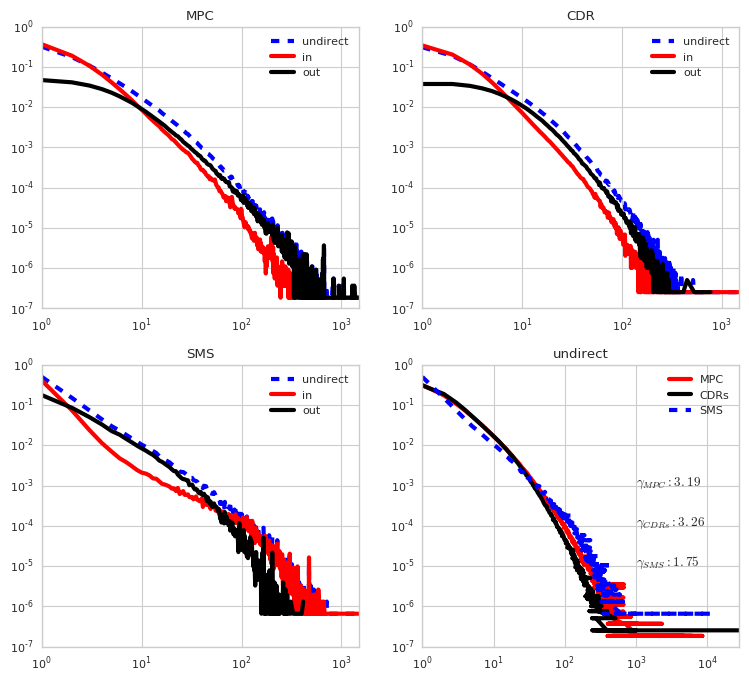

In [737]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 8))
ax1,ax2,ax3,ax4=axes.flatten()
inoutPlot(mpc_deg,'MPC',ax=ax1)
inoutPlot(cdr_deg,'CDR',ax=ax2)
inoutPlot(sms_deg,'SMS',ax=ax3)
deg(mpc_degree).plot(logx=True,logy=True,color='r',label='MPC',linewidth=3,ax=ax4)
deg(cdr_degree).plot(logx=True,logy=True,color='k',label='CDRs',linewidth=3,ax=ax4)
deg(sms_degree).plot(logx=True,logy=True,color='b',ax=ax4,linestyle='--',label='SMS',linewidth=3)
# ax.set_xlim(0,1200)
# ax.legend()
# plt.subplot(122)
ax4.text(1000,0.001,'$\gamma_{MPC}:3.19$')
ax4.text(1000,0.0001,'$\gamma_{CDRs}:3.26$')
ax4.text(1000,0.00001,'$\gamma_{SMS}:1.75$')
ax4.set_title('undirect')
ax4.legend()

In [734]:
import matplotlib.pyplot as plt
cum=lambda  df:df.cumsum()/df.sum()
deg=lambda  df:df[0].value_counts()/float(df.shape[0])
from scipy import stats
def Power_law(df):
    x=np.log(df.index.values)
    y=np.log(df.values)
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(x, y)
    return slope,p_value,r_value,slope_std_error

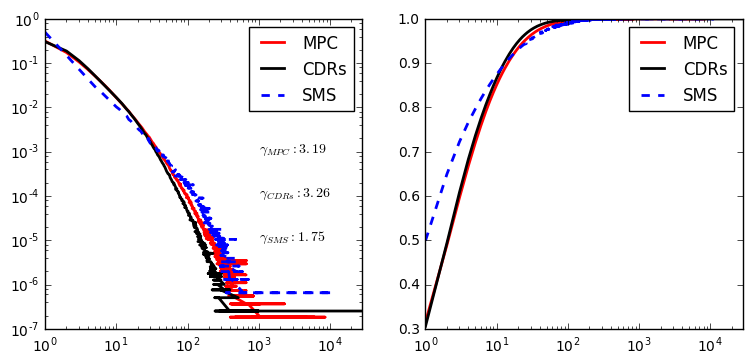

In [79]:
fig,(ax,ax1)=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
# plt.subplot(121)
deg(mpc_degree).plot(logx=True,logy=True,color='r',label='MPC',linewidth=2,ax=ax)
deg(cdr_degree).plot(logx=True,logy=True,color='k',label='CDRs',linewidth=2,ax=ax)
deg(sms_degree).plot(logx=True,logy=True,color='b',ax=ax,linestyle='--',label='SMS',linewidth=2)
# ax.set_xlim(0,1200)
# ax.legend()
# plt.subplot(122)
ax.text(1000,0.001,'$\gamma_{MPC}:3.19$')
ax.text(1000,0.0001,'$\gamma_{CDRs}:3.26$')
ax.text(1000,0.00001,'$\gamma_{SMS}:1.75$')
cum(mpc_degree[0].value_counts()).plot(logx=True,color='r',ax=ax1,label='MPC',linewidth=2)
cum(cdr_degree[0].value_counts()).plot(color='k',label='CDRs',linewidth=2,ax=ax1)
cum(sms_degree[0].value_counts()).plot(color='b',ax=ax1,linestyle='--',label='SMS',linewidth=2)

ax1.legend()
ax.legend()

In [61]:
float(cdr_degree[0].shape[0])

3951237.0

In [719]:
import igraph  as ig

In [745]:
cdr_dd=getInOut(CDR)
sms_dd=getInOut(SMS)
mpc_dd=getInOut(MPC)

In [750]:
def getPal(df):
    tt=[]
    for name  in cdr_dd.columns:
        al=ig.power_law_fit(df[name].values).alpha
        tt.append(al)
    return tt

In [751]:
cdrp=getPal(cdr_dd)
smsp=getPal(sms_dd)
mpcp=getPal(mpc_dd)

In [748]:
cdr_dd.columns

Index([u'indeg', u'outdeg', u'deg'], dtype='object')

In [752]:
mpcp

[3.7394892359947245, 3.141709236572107, 3.1897213597143566]

In [753]:
cdrp

[4.4821434810447585, 6.3343228558672235, 3.2616538014187713]

In [754]:
smsp

[4.425755212095867, 5.514155832105975, 1.7545337496044426]

In [756]:
100**(-2)

0.0001

In [720]:
ig.power_law_fit(cdr_dd.indeg.values)

FittedPowerLaw(continuous=False, alpha=4.4821434810447585, xmin=80.0, L=-6371.185635986731, D=0.012154643578956181, p=0.9833497556934303)

In [738]:
ig.power_law_fit(cdr_dd.outdeg.values).alpha

6.3343228558672235

In [724]:
ig.power_law_fit(cdr_dd.deg.values)

FittedPowerLaw(continuous=False, alpha=3.2616538014187713, xmin=37.0, L=-292667.8531096729, D=0.024667323754087422, p=4.7471931220797675e-37)

In [120]:
p=ig.power_law_fit(mpc_degree.values)

In [122]:
p.alpha

3.1897213597143566

In [77]:
ig.power_law_fit(cdr_degree.values)

FittedPowerLaw(continuous=False, alpha=3.2616538014187713, xmin=37.0, L=-292667.8531096729, D=0.024667323754087422, p=4.7471931220797675e-37)

In [81]:
ig.power_law_fit(sms_degree.values)

FittedPowerLaw(continuous=False, alpha=1.7545337496044426, xmin=1.0, L=-3341045.8284033225, D=0.01649548710123594, p=0.0)

###   中观分析

In [ ]:
min_degree=3
v3=MaxScc.vs.select(_degree_gt=min_degree)   ## 选择度大于1的节点并组成子图 ；尽量去除那些叶子节点
rel_net=MaxScc.subgraph(v3)               ## 并构成子图求出子图中的最大联通分量
rel_net=rel_net.decompose(maxcompno=True)[0]

In [26]:
sms_comp=SMS.components(mode=1)

In [28]:
%time sms_sub=sms_comp.subgraphs()

KeyboardInterrupt: 

####   年龄不同

In [776]:
def getDeg(G):
    
    name=G.vs['name']
    names_df=pd.DataFrame(name,index=name,columns=['id'])
    dfg=names_df.join(userinfo)
    dfg['deg']=G.degree()
    dfg['indeg']=G.indegree()
    dfg['outdeg']=G.outdegree()
    dfg['coef']=G.transitivity_local_undirected() 
    dfg['pagerank']=G.pagerank()
    dfg.drop(['id'],axis=1,inplace=True)
    cond=(dfg.age>18)&(dfg.age<56)&(dfg.outdeg<50)&(dfg.indeg<50)
    
    return dfg[cond].dropna()

def getFGraph(G):
      
    name=G.vs['name']
    names_df=pd.DataFrame(name,index=name,columns=['id'])
    dfg=names_df.join(userinfo)
    dfg=dfg.fillna({'age':0.0,'sex':'unkown'})
    G.vs['age']=dfg.age.values
    G.vs['sex']=dfg.sex.values
    
    return G

by_age_sex=lambda df:df.groupby('age',group_keys=False).apply(lambda x:x.groupby('sex').mean())


In [30]:
userinfo=pd.read_csv('chapter1data/user_info.csv',index_col=0)

In [777]:
sms_df=getDeg(SMS)
cdr_df=getDeg(CDR)
mpc_df=getDeg(MPC)


In [259]:
sns.set_context('paper')
sns.set_style('whitegrid')

In [648]:
SMS.transitivity_local_undirected()  ##节点狙击洗漱

[0.022058823529411766,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.09090909090909091,
 0.01161995898838004,
 nan,
 nan,
 0.0,
 0.004414715719063545,
 0.011695906432748537,
 0.0037160906726124115,
 0.0,
 0.006623577800331179,
 0.0007404664938911515,
 0.0,
 0.20307692307692307,
 0.034658511722731905,
 0.14926975945017182,
 0.4522772277227723,
 0.1695906432748538,
 0.046153846153846156,
 0.0033333333333333335,
 0.0,
 0.21082621082621084,
 0.021739130434782608,
 0.0,
 0.0,
 0.6799950787401575,
 0.70734434124527,
 0.0,
 nan,
 0.19047619047619047,
 0.1076923076923077,
 0.0,
 0.001644157369348209,
 nan,
 0.0,
 0.10446009389671361,
 0.16892964203844119,
 0.07894736842105263,
 0.00868518809187464,
 nan,
 0.0,
 0.22016651248843663,
 0.17962340689613418,
 0.0,
 0.0,
 0.039886039886039885,
 0.020284697508896797,
 0.012987012987012988,
 0.0023334056869980463,
 0.28752642706131076,
 0.3015399500120938,
 0.1761904761904762,
 0.04523996852871755,
 0.22857142857142856,
 0.007246376811594203,
 0.1316292403248925,


In [482]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def plotDeg(cdr_df):
    blue_line = mlines.Line2D([], [], color='c', marker='o',
                              markersize=6, label='male')
    blue_ls = mlines.Line2D([], [], color='c', marker='D',
                              markersize=6, label='female')

    deg= mlines.Line2D([], [], color='k',
                              markersize=6, label='MPC')
    indeg= mlines.Line2D([], [], color='b', 
                              markersize=6, label='CDR')
    outdeg= mlines.Line2D([], [], color='r',
                              markersize=6, label='SMS')
    tt=by_age_sex(cdr_df)
    ax=tt.loc['male'].set_index('age').plot(marker='o',color=['k','b','r'],label='femle',)
    tt.loc['female'].set_index('age').plot(marker='D',ax=ax,color=['k','b','r'])
    ax.legend(handles=[blue_line,blue_ls,deg,indeg,outdeg],loc=1)
    return ax
# ax.legend()

In [582]:
cdr_tt=by_age_sex(cdr_df.ix[:,:3])
cdr_tt=by_age_sex(cdr_df.ix[:,:3])
cdr_tt=by_age_sex(cdr_df.ix[:,:3])

# tt.reset_index(inplace=True)

In [635]:
def getSex(df,l=None,ax1=None):
    blue_line = mlines.Line2D([], [], color='b', linestyle='--',
                              markersize=6, label='male')
    blue_ls = mlines.Line2D([], [], color='g', marker='*',
                              markersize=6, label='female')
    labels=['age','sex']+[l]
    tt=by_age_sex(df.ix[:,labels])
    ax=tt.loc['male'].set_index('age').plot(style='--b',ax=ax1,label='male',legend=False)
    ax=tt.loc['female'].set_index('age').plot(ax=ax,style='-g*',legend=False)
    ax.legend(handles=[blue_line,blue_ls],loc=3)
    return ax


### 年龄与性别上的差异

In [761]:
cutage=lambda   df:df[df.age<56]
sms_df=cutage(sms_df)
mpc_df=cutage(mpc_df)
# cdr_df=cutage(cdr_df)

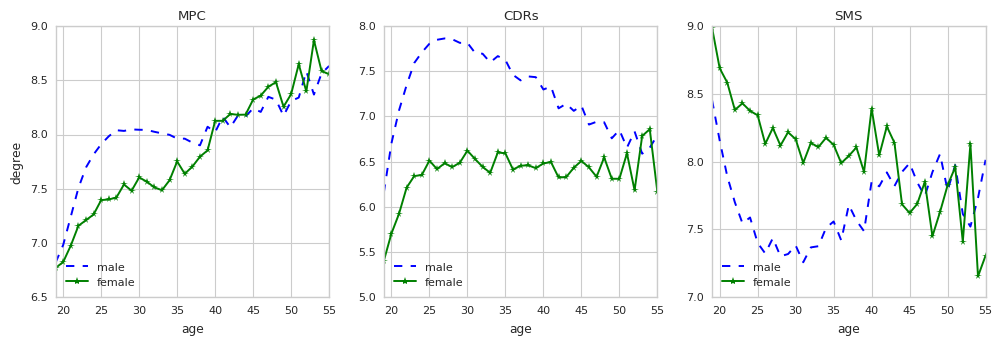

In [794]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5),sharex=True)
axe=axes.flatten()
getSex(mpc_df,'deg',ax1=axe[0])
# getSex(mpc_df,'indeg',ax1=axe[1])
# getSex(mpc_df,'outdeg',ax1=axe[2])
# axe[0].set_title('Deg')
axe[0].set_title('MPC')
axe[0].set_ylabel('degree')

# axe[1].set_title('InDeg')
# axe[2].set_title('OutDeg')

getSex(cdr_df,'deg',ax1=axe[1])
# getSex(cdr_df,'indeg',ax1=axe[4])
# getSex(cdr_df,'outdeg',ax1=axe[5])

getSex(sms_df,'deg',ax1=axe[2])
# getSex(sms_df,'indeg',ax1=axe[7])
# getSex(sms_df,'outdeg',ax1=axe[8])
axe[1].set_title('CDRs')
axe[2].set_title('SMS')


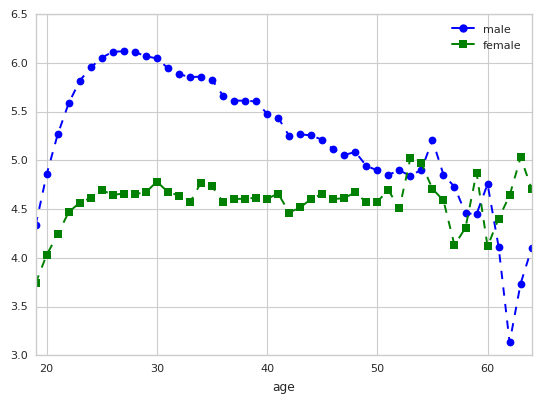

In [607]:
getSex(cdr_df,'deg')

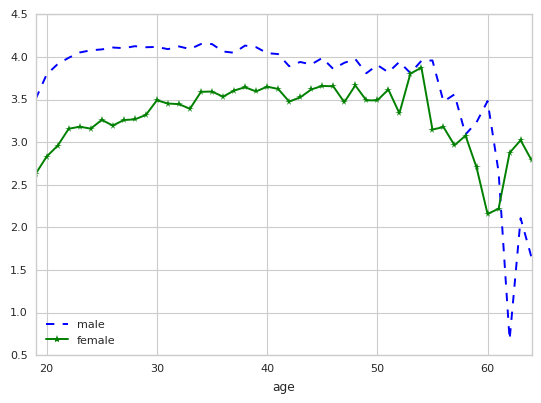

In [655]:
getSex(cdr_df,'outdeg')

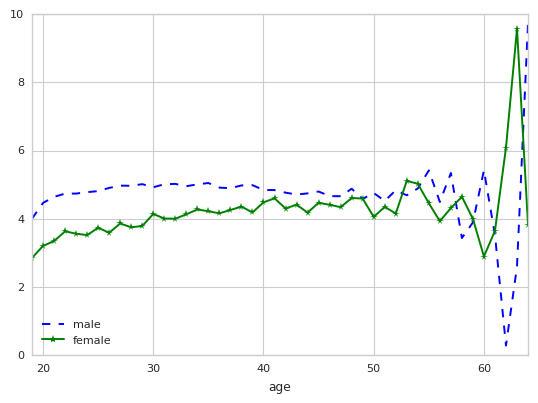

In [656]:
getSex(cdr_df.ix[sms_mpc_cdr,:],'outdeg')

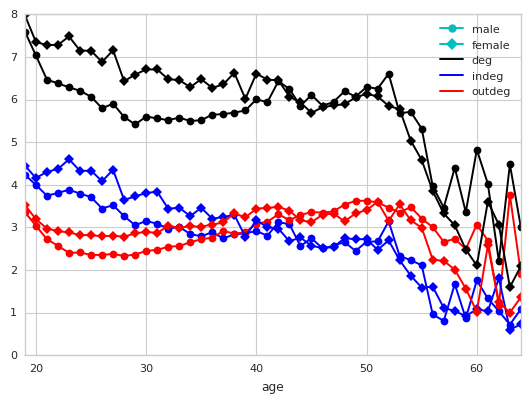

In [380]:
smsf_df=sms_df[sms_df.deg<500]
plotDeg(sms_df)

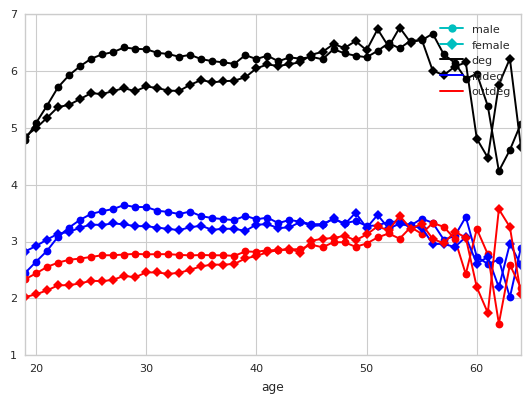

In [381]:
plotDeg(mpc_df)

In [351]:
mpc_df.groupby('age')['deg'].mean().values

array([ 5.18681783,  5.45586467,  5.72986402,  6.06239812,  6.28602589,
        6.43924996,  6.59408488,  6.67560163,  6.69330427,  6.79666054,
        6.78013014,  6.82934696,  6.71508096,  6.72766607,  6.70037406,
        6.76450154,  6.73745274,  6.72182122,  6.73154238,  6.69896866,
        6.90110903,  6.89501462,  6.94877446,  6.91655478,  6.97928293,
        6.99225206,  7.03932298,  7.07425383,  7.22706588,  7.22633758,
        7.2745308 ,  7.24545197,  7.39578407,  7.63788987,  7.56455618,
        7.44380437,  7.57874564,  7.63209494,  7.1304    ,  7.02107112,
        6.79495614,  6.24796748,  5.43843844,  5.20627803,  5.32432432,
        5.28030303])

In [375]:
deg=np.array([mpc_df.groupby('age')['deg'].mean().values,cdr_df.groupby('age')['deg'].mean().values,smsf_df.groupby('age')['deg'].mean().values])

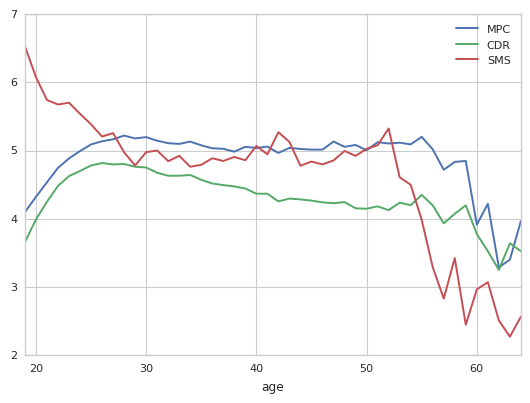

In [376]:
pd.DataFrame(deg.T,index=mpc_df.groupby('age')['deg'].mean().index,columns=['MPC',"CDR",'SMS']).plot()

In [411]:
sms_mpc=np.intersect1d(sms_df.index.values,mpc_df.index.values)
sms_mpc_cdr=np.intersect1d(sms_mpc,cdr_df.index.values)

In [419]:
x,y,z=mpc_df.ix[sms_mpc_cdr,:],cdr_df.ix[sms_mpc_cdr,:],sms_df.ix[sms_mpc_cdr,:]

In [422]:
xy=x.join(y,rsuffix='_cdr')
xyz=xy.join(z,rsuffix='_sms')

In [423]:
xyz.head(3)

,age,sex,deg,indeg,outdeg,age_cdr,sex_cdr,deg_cdr,indeg_cdr,outdeg_cdr,age_sms,sex_sms,deg_sms,indeg_sms,outdeg_sms
35,30.0,male,4,1,3,30.0,male,1,1,0,30.0,male,1,1,0
63,33.0,male,17,17,0,33.0,male,4,4,0,33.0,male,1,1,0
66,24.0,male,2,2,0,24.0,male,7,7,0,24.0,male,1,1,0


In [470]:
by_age_sexL=lambda df,labels:df.groupby('age',group_keys=False).apply(lambda x:x.groupby('sex')[labels].mean())


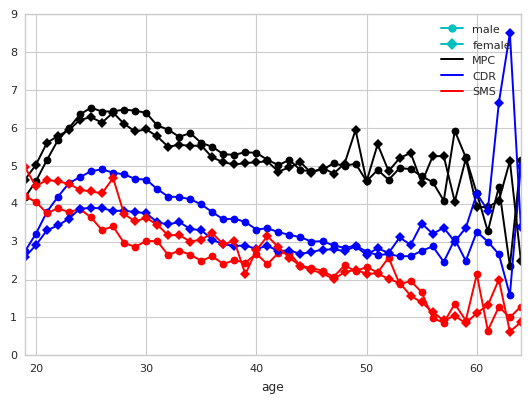

In [483]:
plotDeg(xyz.ix[:,['age','sex','indeg','indeg_cdr','indeg_sms']])

In [ ]:
xyz['cdr_ERR']=xyz.deg_cdr.values/xyz.deg.values.astype('float')
xyz['sms_ERR']=xyz.deg_sms.values/xyz.deg.values.astype('float')


In [706]:
xyz=cutage(xyz)

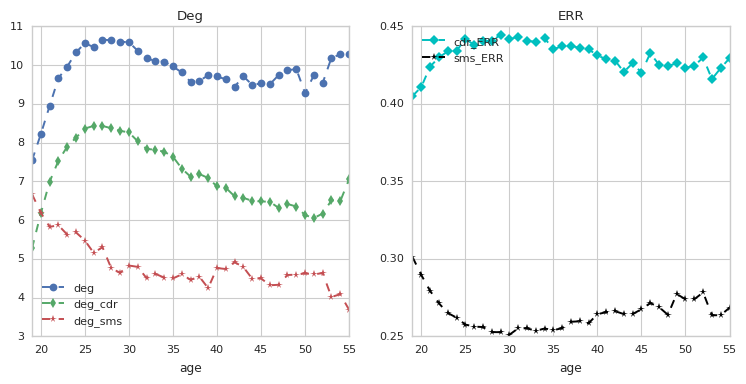

In [785]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),sharex=True)
ax1,ax2=axes.flatten()
xyz.groupby('age')['deg','deg_cdr','deg_sms'].mean().plot(ax=ax1,title='Deg',style=['--o','--d','--*'])
# xyz.groupby('age')['indeg','indeg_cdr','indeg_sms'].mean().plot(ax=ax2,title='InDeg',style=['--o','--d','--*'])
# xyz.groupby('age')['outdeg','outdeg_cdr','outdeg_sms'].mean().plot(ax=ax3,title='OutDeg',style=['--o','--d','--*'])
ax2=xyz[xyz.cdr_ERR<1.0].groupby('age')['cdr_ERR'].mean().plot(ax=ax2,style='--cD')
xyz[xyz.sms_ERR<1.0].groupby('age')['sms_ERR'].mean().plot(ax=ax2,style='--k*')
ax2.legend(loc=2)
ax2.set_title('ERR')

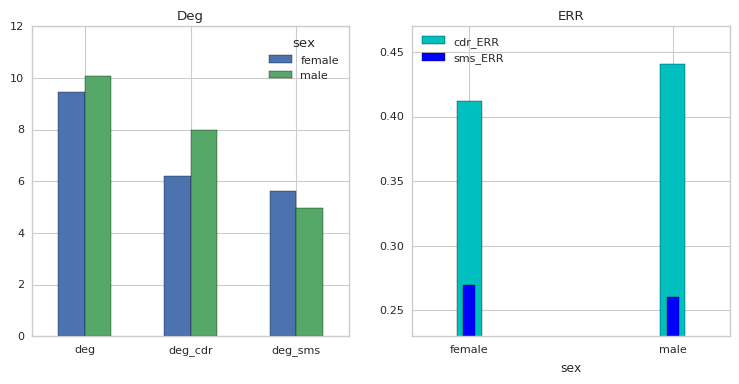

In [786]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1,ax4=axes.flatten()
xyz.groupby('sex')['deg','deg_cdr','deg_sms'].mean().T.plot.bar(title='Deg',ax=ax1,rot=0)
# xyz.groupby('sex')['indeg','indeg_cdr','indeg_sms'].mean().T.plot.bar(title='Indeg',ax=ax2,rot=0)
# xyz.groupby('sex')['outdeg','outdeg_cdr','outdeg_sms'].mean().T.plot.bar(title='OutDeg',ax=ax3,rot=0)
ax4=xyz[xyz.cdr_ERR<1.0].groupby('sex')['cdr_ERR'].mean().T.plot.bar(ax=ax4,width=0.12,color='c',ylim=[0.23,0.47],rot=0)
xyz[xyz.sms_ERR<1.0].groupby('sex')['sms_ERR'].mean().T.plot.bar(ax=ax4,color='b',width=0.06,rot=0)
ax4.legend(loc=2)
ax4.set_title('ERR')

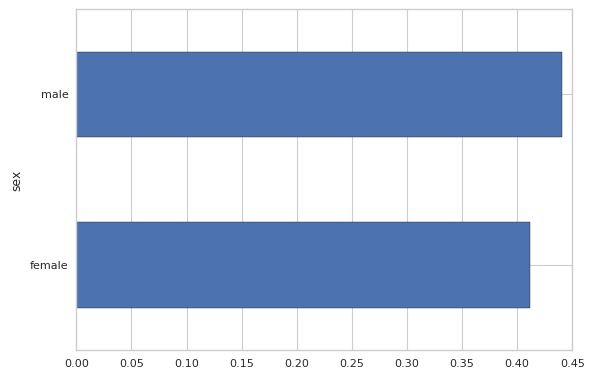

In [533]:
xyz[xyz.cdr_ERR<1.0].groupby('sex')['cdr_ERR'].mean().T.plot.barh()

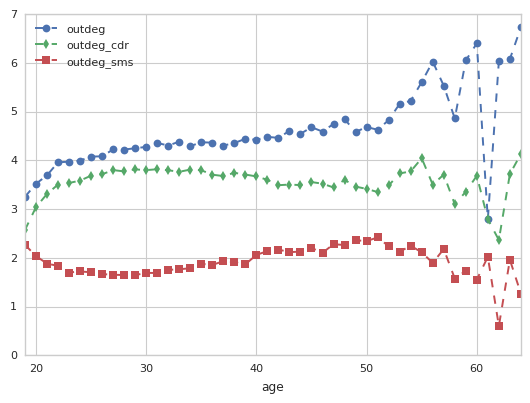

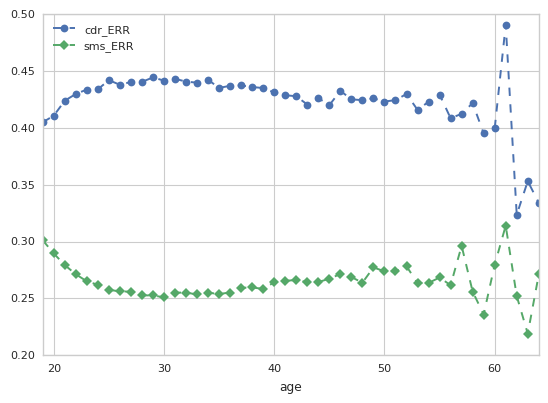

In [501]:
ax=xyz[xyz.cdr_ERR<1.0].groupby('age')['cdr_ERR'].mean().plot(style='--o')
xyz[xyz.sms_ERR<1.0].groupby('age')['sms_ERR'].mean().plot(ax=ax,style='--D')
ax.legend(loc=2)

In [568]:
zz=by_age_sexL(xyz,['deg','deg_cdr','deg_sms'])

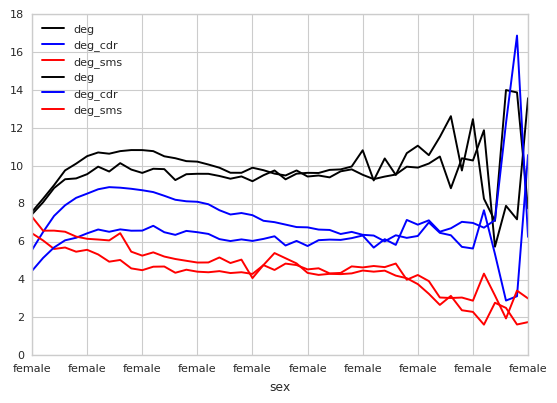

In [569]:
ax=zz.loc['male'].plot(color=['k','b','r'])
zz.loc['female'].plot(ax=ax,color=['k','b','r'])

(0.05, 0.16)

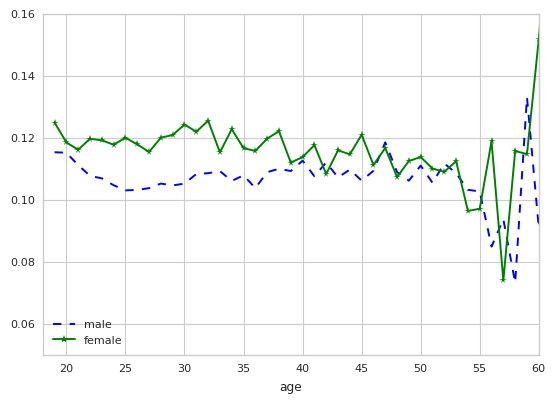

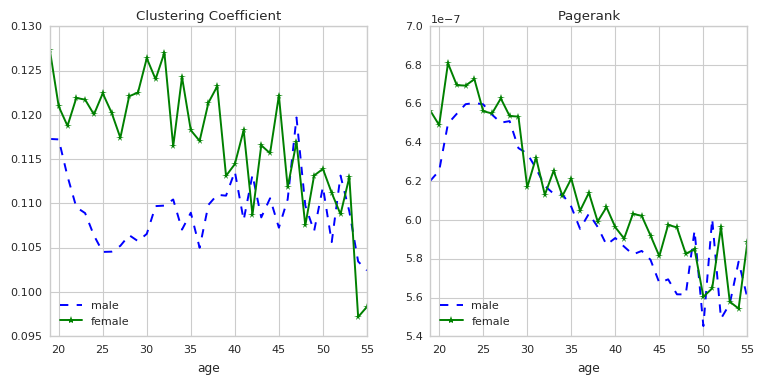

In [781]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1,ax2=axes.flatten()
getSex(sms_df[sms_df.age<56],'coef',ax1=ax1)
ax1.set_title('Clustering Coefficient')
# ax1.set_xlim([18,55])
# ax1.set_ylim([0.07,0.30])
getSex(sms_df[sms_df.age<56],'pagerank',ax1=ax2)
ax2.set_title('Pagerank')

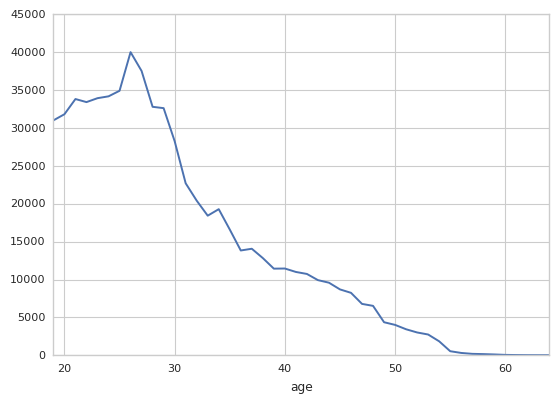

In [687]:
sms_df.groupby('age')['sex'].count().plot()

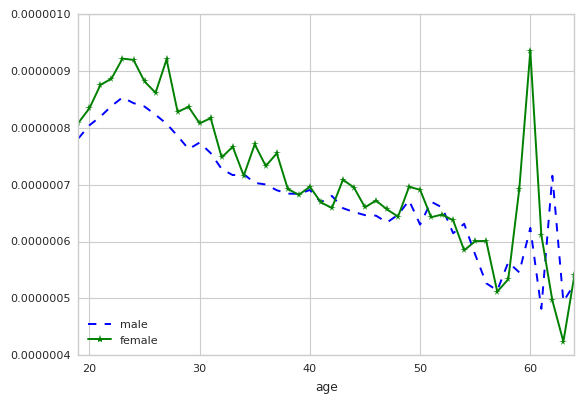